<div style="text-align: right; font-style: italic">Lorenz Köhl
<br>
December 2022</div>


# EU Official Journal semantic search (WIP)

This notebook shows how to prepare the EU official journal data for programmatic use, for example to use in ML applications (eg. download, deduplication, parsing etc.)

### Imports and setup

In [ ]:
#!pip install sparqlwrapper
#!pip install plotnine

In [1]:
import numpy as np
import pandas as pd

from SPARQLWrapper import SPARQLWrapper, JSON

import urllib3
import json
from urllib.parse import unquote_plus
from zipfile import ZipFile, BadZipFile

from io import StringIO, BytesIO
import xml.etree.ElementTree as ET

from string import Template

import concurrent.futures
# plotting libs
import matplotlib.pyplot as plt
import plotnine as p9

# suppress plotnine warnings
import warnings
warnings.filterwarnings('ignore')

# setup plotnine look and feel
p9.theme_set(
  p9.theme_grey() + 
  p9.theme(text=p9.element_text(size=10),
        plot_title=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=12),
        axis_title_y=p9.element_text(size=12),
        axis_text_x=p9.element_text(size=8),
        axis_text_y=p9.element_text(size=8)
       )
)
xlabels_90 = p9.theme(axis_text_x = p9.element_text(angle=90, hjust=1))

pd.set_option('display.precision', 2)

### Download utilities 

For downloading the EU Official Journal.

A SPARQL query is used by EUR-Lex to provide access to files.  
It generates a tabulation of URLs to download zipped document collections which appeared in a given year in the column `fmx4_to_download`

In [50]:
query_template = Template("""\
PREFIX cdm: <http://publications.europa.eu/ontology/cdm#>
SELECT distinct ?OJ ?title_ group_concat(distinct ?author; separator=",") as ?authors ?date_document ?manif_fmx4 ?fmx4_to_download
WHERE 
{
  ?work a cdm:official-journal.
  ?work cdm:work_date_document ?date_document.
  FILTER(substr(str(?date_document),1,4)='$year')
  ?work cdm:work_created_by_agent ?author.
  ?work owl:sameAs ?OJ.
  FILTER(regex(str(?OJ),'/oj/'))
  OPTIONAL{?exp cdm:expression_title ?title.
    ?exp cdm:expression_uses_language ?lang.
    ?exp cdm:expression_belongs_to_work ?work.
    FILTER(?lang =<http://publications.europa.eu/resource/authority/language/ENG>)
    OPTIONAL{?manif_fmx4 cdm:manifestation_manifests_expression ?exp.
      ?manif_fmx4 cdm:manifestation_type ?type_fmx4.
      FILTER(str(?type_fmx4)='fmx4')
    }
  }
  BIND(IF(BOUND(?title),?title,'The Official Journal does not exist in that language'@en) as ?title_)
  BIND(IF(BOUND(?manif_fmx4),IRI(concat(?manif_fmx4,"/zip")),"") as ?fmx4_to_download)
} order by ?date_document
""")

def query_OJ_urls(year: int) -> [str]:
    "Return a list of download URLs for OJ documents of a given year"
    sparql = SPARQLWrapper('http://publications.europa.eu/webapi/rdf/sparql')
    sparql.setReturnFormat(JSON)
    sparql.setQuery(query_template.substitute(year=year))
    try:
        ret = sparql.queryAndConvert()
        fmx4s = [r["fmx4_to_download"] for r in ret["results"]["bindings"]]
        dl_uris = [o['value'] for o in fmx4s if o['type'] == 'uri']
        return dl_uris
    except Exception as e:
        print(e)

def download_xml_zip(url, http, timeout=28.0) -> dict:
    "Download the zip at the given URL. Provide a dict from xml filenames to xml content"
    with BytesIO() as f:
        r = http.request('GET', url, timeout=timeout)
        if r.status == 200: # urllib3 follows three redirects by default
            f.write(r.data)
            z = ZipFile(f)
            return {name: z.read(name).decode('utf-8')
                    for name in z.namelist() if name.endswith('.xml')}
        else:
            raise urllib3.exceptions.HTTPError(f'HttpError {r.status}: {r.data.decode("utf-8")}')

def download_OJ_year(year) -> [dict]:
    """ Download all files from the EU Official Journal for the given year, concurrently.
        Provides a list of dictionaries which map filenames to file content """
    # We will download documents in parallel using a thread pool
    # Must set connection pool size >1 to get parallel DLs
    http = urllib3.PoolManager(maxsize=10)
    urls = query_OJ_urls(year)

    print(f'Downloading {len(urls)} URLs for {year}')
    
    result = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        load_fn = download_xml_zip
        future_url = {executor.submit(load_fn, url, http): url for url in urls}
        for future in concurrent.futures.as_completed(future_url):
            url = future_url[future]
            try:
                dictionary = future.result()
                result.append(dictionary)
            except Exception as exc:
                print('%r: %s' % (url, exc))
    return result

### A database of documents

To cleanly separate the data downloading part from the rest of the project, create a simple sqlite database to keep the raw XML of the official journal documents on disk.

Note that the downloaded archives contain many repeated files with the same content: here we get extra value from sqlite, which deduplicates the data for us, by defining a primary key over the file content. This way we don't have to write extra logic to ensure uniqueness.

In [28]:
import sqlite3
from itertools import islice

In [29]:
def batched(iterable, n): # useful for eg. batching sqlite transactions or downloads, included in python 3.12
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while (batch := tuple(islice(it, n))):
        yield batch

In [30]:
raw_docs_table_sql = """\
create table if not exists oj (
  year integer not null,
  filename text not null,
  content text not null,
  primary key (year, filename, content)
);
"""
raw_docs_insert_sql = "insert into oj (year, filename, content) values (:year, :filename, :content)"

In [40]:
def insert_file_dicts(con, year, file_dicts: [dict]):
    "Insert dictionaries representing xml files into the given sqlite DB"
    count = 0
    for batch in batched(file_dicts, 50):
        con.execute('BEGIN TRANSACTION')
        for dic in batch:
            for filename, content in dic.items():
                d = dict(filename=filename, content=content, year=year)
                try:
                    con.execute(raw_docs_insert_sql, d)
                    count += 1
                except sqlite3.IntegrityError:
                    pass # ignore duplicate files present in the data
        con.execute('COMMIT')
    print(f'Inserted {count} files')

In [32]:
con = sqlite3.connect("eurlex.db")
con.execute(raw_docs_table_sql);

In [491]:
con.close()

Download the OJ documents into sqlite to create the basis the dataset

In [ ]:
%%time
for year in range(2009, 2023):
    file_dicts = download_OJ_year(year)
    insert_file_dicts(con, year, file_dicts)

In [39]:
!du -sh eurlex.db

8.8G	eurlex.db


### XML utilities

The documents from the official journal are formated in an XML schema called Formex. We transform the files into python dictionaries to make them easier to handle with python

In [132]:
def xml_dict(parse_events) -> dict:
    """ Create a nested python dict from a sequence of xml parse events
        Collects children by tag name, and ignores order of appearance of distinct tags """
    nodes = [dict()]
    for ev, el in parse_events:
        if ev == 'start':
            parent, child = nodes[-1], dict()
            match parent:
                case {el.tag: dict() as sibling}:
                    parent[el.tag] = [sibling, child]
                case {el.tag: list() as l}:
                    l.append(child)
                case _:
                    parent[el.tag] = child              
            nodes.append(child)
        elif ev == 'end':
            node = nodes.pop()
            if el.attrib: node['attr'] = el.attrib
            if el.text: node['text'] = el.text
    return nodes.pop()

def doc_dict(doc: str) -> dict:
    "Tree repr of xml document"
    with StringIO(doc) as f:
        return xml_dict(ET.iterparse(f, events=('start', 'end')))

Here is a small test that illustrates the use of `xml_dict`:

In [44]:
xml_test = """
<doc>
    <p><a href="baz">foo</a><b>zod</b></p>
    <p>bar</p>
</doc>"""
with StringIO(xml_test) as f:
    test_dict = xml_dict(ET.iterparse(f, events=('start', 'end')))
    assert len(test_dict['doc']['p']) == 2 # <doc> has two <p> children
    print(test_dict)

{'doc': {'p': [{'a': {'attr': {'href': 'baz'}, 'text': 'foo'}, 'b': {'text': 'zod'}}, {'text': 'bar'}], 'text': '\n    '}}


Since we represent parsed documents as a tree containing dictionaries and lists we also need a utility to linearize this representation. For example to create sentences of (parts of) a document we are interested in:

In [45]:
def string_items(root: dict):
    "Generate all key-value pairs contained in (nested) dict, where value is of type string"
    for item in root.items():
        match item:
            case (_, dict() as d):
                yield from string_items(d)
            case (_, list() as lst):
                for el in lst:
                    if type(el) is dict:
                        yield from string_items(el)
            case (k, str() as s):
                yield (k, s)
            case _: return

def dict_text(d: dict) -> str:
    "Given a document tree, append all ['text'] values to form a string"
    return ' '.join(v.strip() for k,v in string_items(d) if k == 'text').strip()

Continuing the example we get:

In [46]:
dict_text(test_dict)

'foo zod bar'

### Preliminary data analysis

To get an idea of the size and shape of data we start with plots and summaries of the raw data

In [47]:
con = sqlite3.connect("eurlex.db")

In [69]:
pd.options.display.float_format = '{:.2f}'.format

In [99]:
sql_oj_lengths = 'select length(content) from oj where year = {}'
df2009 = pd.DataFrame.from_records(
    con.execute(sql_oj_lengths.format(2009)).fetchall(),
    columns=['length2009']
)
df2021 = pd.DataFrame.from_records(
    con.execute(sql_oj_lengths.format(2021)).fetchall(),
    columns=['length2021']
)

In [104]:
df = df2009.join(df2021)
df.describe()

,length2009,length2021
count,20353.00,20353.00
mean,11146.11,13884.61
std,91484.53,107381.84
min,702.00,715.00
25%,1516.00,1445.00
50%,2474.00,2203.00
75%,5560.00,5181.00
max,5373611.00,9035052.00


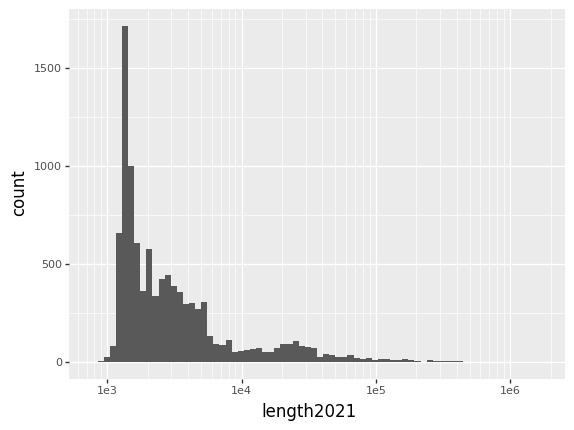

<ggplot: (8756256280075)>

In [107]:
(p9.ggplot(data=df.head(10000), mapping=p9.aes(x='length2021'))
    + p9.geom_histogram()
    + p9.scale_x_log10()
)

Most documents are in the thousands of characters (including markup)

### Extracting sentences

Metadata about publication is contained in the `*.doc.*` xml files. We can pattern match on the dictionary representation of a document to extract some metadata we're interested in

In [111]:
def get_metadata(meta_dict_doc: dict) -> dict:
    match meta_dict_doc['DOC']:
        case {'FMX': {'DOC.MAIN.PUB': {'LEGAL.VALUE': {'text': legval},
                                       'REF.PHYS': {'attr': {'FILE': file,}}}},
              'BIB.DOC': {'AUTHOR': {'text': author}},
              'PAPER': {'VOLUME.PAPER': {'ITEM.VOLUME': {'TITLE': {'TI': {'P': {'text': title}}}}}}}:
            return {'legal_value': legval,
                    'filename': file,
                    'author': author,
                    'title': title}

def parse_metadata(meta_doc: str) -> dict:
    events = ET.iterparse(StringIO(meta_doc), events=('start', 'end'))
    dict_doc = xml_dict(events)
    return get_metadata(dict_doc)

In [109]:
metadocs = con.execute("""\
  select content from oj where filename like '%.doc.%' and year = 2021
""").fetchall()

In [122]:
metadata = [parse_metadata(metadoc[0]) for metadoc in metadocs]
metadata[42]

{'legal_value': 'RECRUIT',
 'filename': 'CA2021342EN.01000101.xml',
 'author': 'COM',
 'title': 'European Union Agency for Law Enforcement Training (CEPOL) – Publication of a vacancy for the function of Executive Director (Temporary Agent\xa0– Grade AD 14) – COM/2021/20066'}

In [124]:
set(m['legal_value'] for m in metadata if m)

{'ACT_ADOPT_INTERNATION',
 'ADD',
 'AGREE',
 'AGREE_AMEND',
 'AGREE_INTERINSTIT',
 'AGREE_INTERNATION',
 'AID_STATE',
 'ANNOUNC',
 'BUDGET',
 'BUDGET_SUPPL_AMEND',
 'COMMUNIC',
 'CONCL',
 'CORRIGENDUM',
 'DATPRO',
 'DEC',
 'DECLAR',
 'DEC_DEL',
 'DEC_IMPL',
 'DIR',
 'DIR_DEL',
 'DIR_IMPL',
 'EXCH_RATE',
 'EXCH_RATE_MRO',
 'GUIDELINE',
 'GUIDELINE_GEN',
 'INFO',
 'INFO_JUDICIAL',
 'JOINT_DEC',
 'MP.EP',
 'NOTE',
 'NOTICE',
 'NOTIF',
 'OPIN',
 'OPIN_EXPLOR',
 'OWNINI_OPIN',
 'OWNINI_OPIN_ADDIT',
 'POSIT',
 'PROC_RULES',
 'RECO',
 'RECRUIT',
 'REG',
 'REG_DEL',
 'REG_IMPL',
 'REPORT',
 'REPORT_ANNUAL',
 'REPORT_ANNUAL_DAS',
 'RES',
 'RES_LEGIS',
 'STAT',
 'STATUTE',
 'STAT_REASON',
 'SUM'}

Let's make sentences for all regulations from the year 2021

In [161]:
def sentences(xml: str) -> [str]:
    dd = doc_dict(xml)
    return [v.strip() for k,v in string_items(dd)
            if k == 'text' and len(v) >= 72]

In [163]:
regs = [m['filename'] for m in metadata if m and m['legal_value'] == 'REG']
cur = con.execute(f"select content from oj where filename in ({','.join(['?']*len(regs))})", regs)
all_reg_sentences2021 = []
for (xmldoc,) in cur.fetchall():
    all_reg_sentences2021.extend(sentences(xmldoc))
all_reg_sentences2021[:3]

['amending Regulation (EC) No 1126/2008 adopting certain international accounting standards in accordance with Regulation (EC) No 1606/2002 of the European Parliament and of the Council as regards International Accounting Standard 39 and International Financial Reporting Standards 4, 7, 9 and 16',
 'Having regard to Regulation (EC) No 1606/2002 of the European Parliament and of the Council of',
 'Regulation (EU) 2016/1011 of the European Parliament and of the Council of']

In [164]:
len(all_reg_sentences2021)

16792

TODO: derive sentences/statements from the document logic

### Embedding Sentences for a Q/A model

(TBD)

To create a natural language interface we apply vector search techniques. See https://github.com/mye/simple-vector-search for a simple introduction to this topic.

In [165]:
import torch, numpy as np
from sentence_transformers import SentenceTransformer